In [64]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from model import lorenz63

plt.style.use('seaborn')

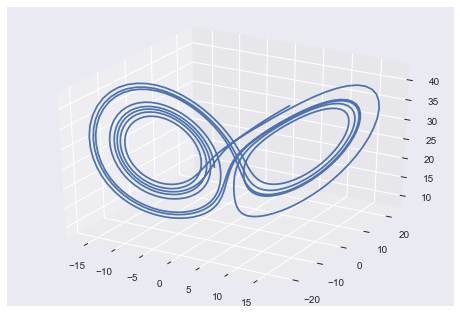

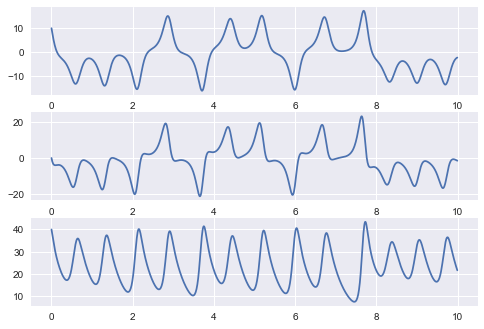

In [65]:
ts = np.arange(0, 10, 0.01)
result = lorenz63([10, 0, 40], ts)
x, y, z = result.y

fig1 = plt.figure()
ax1 = plt.gca(projection='3d')
ax1.plot(x, y, z)

fig2, axs = plt.subplots(nrows=3)
axs[0].plot(ts, x)
axs[1].plot(ts, y)
axs[2].plot(ts, z)

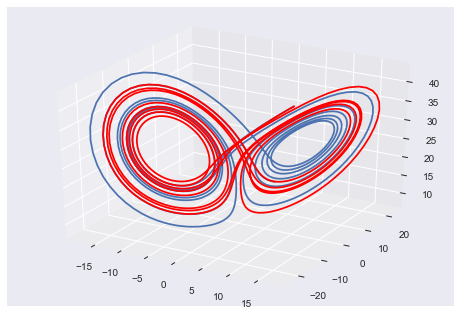

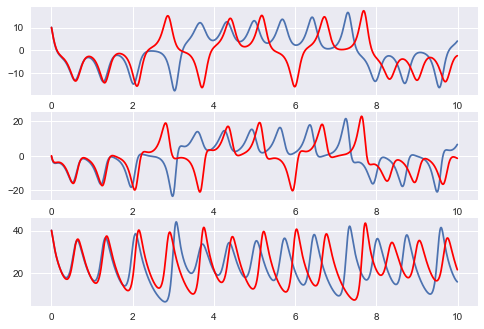

In [66]:
ts = np.arange(0, 10, 0.01)
result = lorenz63([10.1, -0.5, 40.1], ts)
x2, y2, z2 = result.y

fig1 = plt.figure()
ax1 = plt.gca(projection='3d')
ax1.plot(x2, y2, z2)
ax1.plot(x, y, z, color='red')

fig2, axs = plt.subplots(nrows=3)
axs[0].plot(ts, x2)
axs[1].plot(ts, y2)
axs[2].plot(ts, z2)
axs[0].plot(ts, x, color='red')
axs[1].plot(ts, y, color='red')
axs[2].plot(ts, z, color='red')

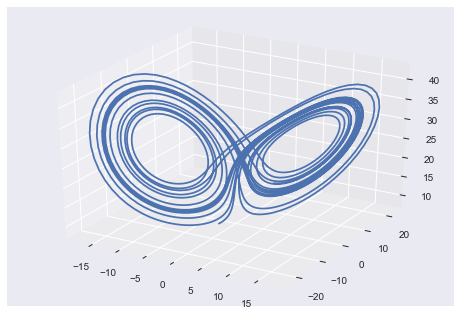

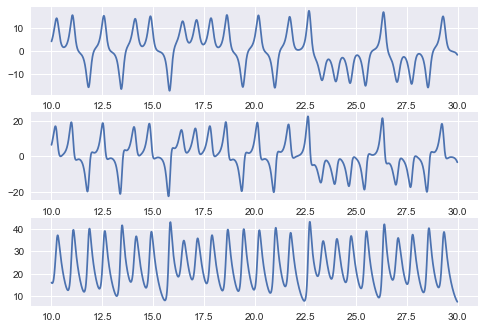

In [67]:
## X = [[x0, x1, x2, ....],
##      [y0, y1, y2, ....],
##      [z0, z1, z2, ....]]


# spin up
spinup_time = 10
dt = 0.01
X0 = np.array([[10.1], [-0.5], [40.1]])
result = lorenz63(X0.ravel(), np.arange(0, spinup_time, dt))
X_spn = result.y

# save nature run
time = 20
dt = 0.01
ts = np.arange(spinup_time, spinup_time+time, dt)
X0 = X_spn[:,[-1]]
result = lorenz63(X0.ravel(), ts)
X_nature = result.y

# plot nature run
fig1 = plt.figure()
ax1 = plt.gca(projection='3d')
ax1.plot(X_nature[0,:], X_nature[1,:], X_nature[2,:])

fig2, axs = plt.subplots(nrows=3)
axs[0].plot(ts, X_nature[0,:])
axs[1].plot(ts, X_nature[1,:])
axs[2].plot(ts, X_nature[2,:])

In [68]:
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        If None, np.random.randint(0, 99) will be used.
        
    Return:
    ------
    An 1d array of random numbers.
    """
    if random_state is None:
        random_state = np.random.randint(0, 99)
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result

In [69]:
obs_mean = 0
obs_var = 1
obs_timeintv = 2
cycle_num = int(time / obs_timeintv)

X_obs_err = np.zeros((3, cycle_num))
for irow, random_state in enumerate([40, 41, 42]):
    X_obs_err[irow,:] = gen_random_normal(obs_mean, obs_var, cycle_num, random_state)
    
X_obs = X_nature[:,::int(obs_timeintv/dt)] + X_obs_err

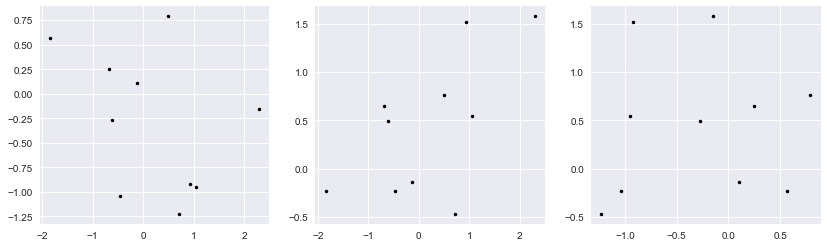

In [70]:
fig, axs = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
axs[0].plot(X_obs_err[0], X_obs_err[1], 'k.')
axs[1].plot(X_obs_err[0], X_obs_err[2], 'k.')
axs[2].plot(X_obs_err[1], X_obs_err[2], 'k.')

In [71]:
# spin up and get initial condition for experiments
# random_state=9 is very close to nature run
X0 = np.array([[10.1], [-0.5], [40.1]]) + gen_random_normal(0, 0.1, size=1, random_state=11)
result = lorenz63(X0.ravel(), np.arange(0, spinup_time, dt))
X_spn = result.y

X_ini = X_spn[:,[-1]]
X_ini

array([[ 5.19051607],
       [ 4.42742825],
       [24.38598899]])

In [72]:
def assimilation_cycle(x0, model, dt, cycle_len, ncycle, scheme, **kwargs):
    result = np.zeros((x0.size, int(cycle_len*ncycle/dt)))
    xb = x0
    t_start = 0
    ts = np.arange(t_start, cycle_len, dt)
    for nc in range(ncycle):
        # calculate analysis field, then forecast
        xa = scheme(xb, **kwargs)
        x = model(xa.ravel(), ts).y
        result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
        
        # for next cycle
        xb = x[:,-1]
        t_start = int(ts[-1] + dt)
        ts = np.arange(t_start, t_start+cycle_len, dt)
        
    return result

In [73]:
def temp_scheme(xb):
    return xb
    
temp_assim = assimilation_cycle(X_ini, lorenz63, dt, 2, 10, temp_scheme)
temp_assim

array([[  5.19051607,   5.12510676,   5.08120553, ...,  -6.19618387,
         -6.60570546,  -7.04189448],
       [  4.42742825,   4.57942967,   4.74838881, ..., -10.15838514,
        -10.83471734, -11.5359382 ],
       [ 24.38598899,  23.973353  ,  23.5772292 , ...,  15.66878087,
         15.91949317,  16.25385653]])

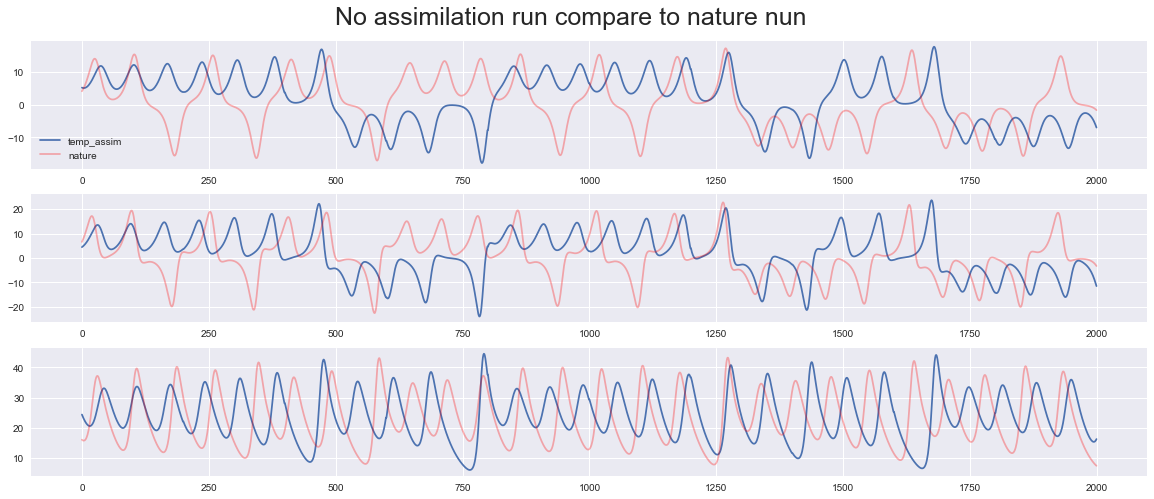

In [74]:
fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
axs[0].plot(temp_assim[0,:], label='temp_assim')
axs[1].plot(temp_assim[1,:])
axs[2].plot(temp_assim[2,:])
axs[0].plot(X_nature[0,:], color='red', alpha=0.3, label='nature')
axs[1].plot(X_nature[1,:], color='red', alpha=0.3)
axs[2].plot(X_nature[2,:], color='red', alpha=0.3)
axs[0].legend()

fig2.suptitle('No assimilation run compare to nature nun', fontsize=25, y=0.94);

In [119]:
def nmc(model, ref, dt, alpha, t1, t2, num):
    result = np.zeros((num, 2, ref[:,0].size))
    interv = int((t2-t1) / dt)
    for n in range(num):
        x0 = ref[:,n*interv]
        ts = np.arange(0, t2-t1, dt)
        xs = model(x0, ts).y
        result[n,0,:] = xs[:,0]
        result[n,1,:] = xs[:,-1]
    """    
    Pb = np.zeros((x0.size, x0.size))
    diff_t2t1 = result[:,1,:] - result[:,0,:]
    for n in range(num):
        Pb += diff_t2t1[n,np.newaxis].T * diff_t2t1[n,:]
        """
    Pb = np.zeros((x0.size, x0.size))
    for n in range(1, num):
        xf_diff = result[n,0,:] - result[n-1,1,:]
        Pb += xf_diff[:,np.newaxis] * xf_diff
        
    return alpha * Pb / num

In [167]:
Pb = nmc(lorenz63, X_nature, dt, 100, 1, 2, 20)
Pb

array([[16.63575603,  7.63157526,  8.6819734 ],
       [ 7.63157526, 25.18777311, 21.73349205],
       [ 8.6819734 , 21.73349205, 76.68241191]])

In [168]:
R = np.eye(3)
R

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [169]:
from assimilation_schemes import OI

In [170]:
cycle_len = 2
ncycle = 10

result = np.zeros((X_ini.size, int(cycle_len*ncycle/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)
for nc in range(ncycle):
    # calculate analysis field, then forecast
    xa = OI(xb, X_obs[:,[nc]], Pb, R)[0]
    x = lorenz63(xa.ravel(), ts).y
    result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)

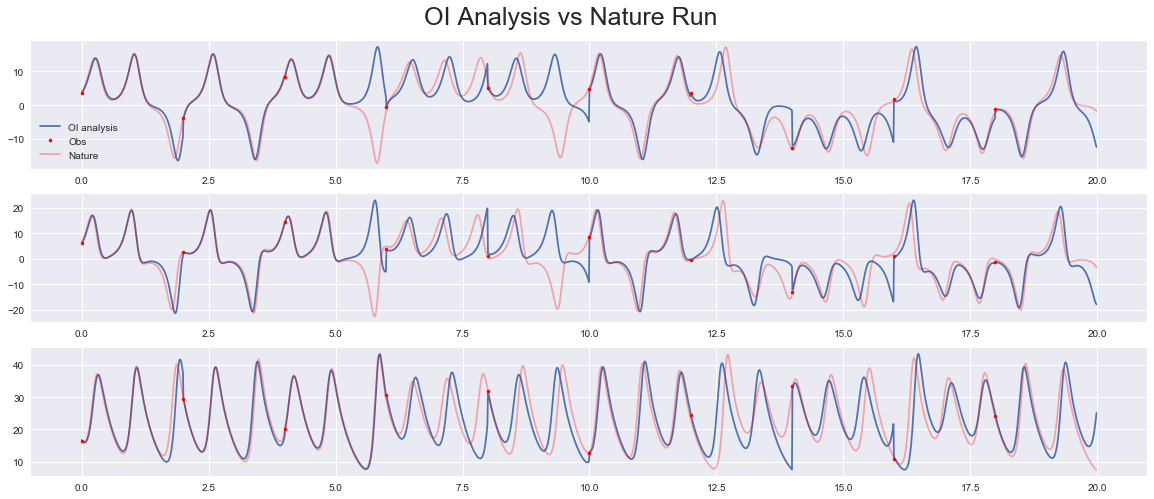

In [171]:
ts = np.arange(0, 20, 0.01)
t_obs = np.arange(0, 20, 2)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='OI analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('OI Analysis vs Nature Run', fontsize=25, y=0.94);